https://podaac.jpl.nasa.gov/dataset/CYGNSS_L3_UC_BERKELEY_WATERMASK_V3.1#

https://podaac.jpl.nasa.gov/dataset/CYGNSS_L3_UC_BERKELEY_WATERMASK_DAILY_V3.2

In [1]:
# pip install earthaccess xarray h5netcdf
import earthaccess as ea

# 1) Log in (opens a device-code prompt) and search
ea.login()


Enter your Earthdata Login username: octavia.v.crompton
Enter your Earthdata password: ········


In [10]:
import cftime

In [11]:
# %% ------------------ Setup ------------------
import os
from pathlib import Path
from typing import Tuple, List

import earthaccess as ea
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ Parameters ------------------
SHORT_NAME = "CYGNSS_L3_UC_BERKELEY_WATERMASK_V3.1"
VERSION    = "3.1"

# Full-range temporal window (broad; server returns only what's available)
TEMPORAL   = ("2016-01-01", "2030-12-31")

# Okavango bbox (min_lon, min_lat, max_lon, max_lat)
OKAV_BBOX = (21.696, -20.223, 24.103, -18.221)

# Output
BASE_OUT   = Path("../data/cygnss_okavango_full")
CROPS_DIR  = BASE_OUT / "crops_nc"
MERGED_NC  = BASE_OUT / "cygnss_okavango_full_merged.nc"
BASE_OUT.mkdir(parents=True, exist_ok=True)
CROPS_DIR.mkdir(parents=True, exist_ok=True)

# ------------------ Helpers ------------------
def find_lat_lon_names(ds: xr.Dataset) -> Tuple[str, str]:
    lat = next(n for n in ds.dims if n.lower() in ("lat","latitude","y"))
    lon = next(n for n in ds.dims if n.lower() in ("lon","longitude","x"))
    return lat, lon



def pick_var_with_latlon(ds: xr.Dataset, lat: str, lon: str) -> str:
    preferred = [v for v in ds.data_vars if ("mask" in v.lower()) or ("water" in v.lower())]
    for v in preferred:
        if {lat, lon}.issubset(ds[v].dims): return v
    for v in ds.data_vars:
        if {lat, lon}.issubset(ds[v].dims): return v
    return list(ds.data_vars)[0]

def aoi_lat_slice(ds: xr.Dataset, lat_name: str, bbox) -> slice:
    lat_vals = ds[lat_name].values
    south, north = bbox[1], bbox[3]
    return slice(north, south) if (lat_vals[0] > lat_vals[-1]) else slice(south, north)

def weights_coslat(lat_vals: np.ndarray) -> np.ndarray:
    return np.cos(np.deg2rad(lat_vals))

def decode_months_since(ds: xr.Dataset, time_name: str = "time") -> pd.DatetimeIndex:
    """
    Convert CF-like 'months since YYYY-MM-DD ...' to pandas datetime without cftime.
    Keeps the same length/ordering as ds[time_name].
    """
    if time_name not in ds:
        raise ValueError("No time coordinate found to decode.")
    t = ds[time_name]
    units = t.attrs.get("units", "")
    # Expect e.g., 'months since 2018-08-01 00:30:00.000000000'
    if "months since" not in units:
        # Fallback: try xarray decode if possible
        try:
            _ = xr.decode_cf(ds)[time_name].to_index()
        except Exception:
            return pd.RangeIndex(len(t))  # unlabeled
        else:
            return xr.decode_cf(ds)[time_name].to_index()

    base_str = units.split("months since", 1)[1].strip().split()[0]  # 'YYYY-MM-DD'
    base = pd.Timestamp(base_str)
    offs = pd.to_numeric(t.values)  # months as integers/floats
    # Build datetime by adding month offsets
    idx = pd.DatetimeIndex([base + pd.DateOffset(months=int(m)) for m in offs])
    return idx

# ------------------ 1) Search (full period) & open authenticated ------------------
ea.login()
results = ea.search_data(
    short_name=SHORT_NAME,
    version=VERSION,
    temporal=TEMPORAL,
    # spatial filter is optional (files are global), but harmless:
    # bounding_box=OKAV_BBOX,
)
files = ea.open(results)  # authenticated file-like objects

print(f"Found {len(files)} monthly files across the full record (server may paginate).")

import re

def month_from_granule(gran) -> str | None:
    """
    Return 'YYYY-MM' by parsing the granule's name/id/URL.
    No temporal metadata, no time decoding.
    """
    # Try producer_granule_id
    name = getattr(gran, "producer_granule_id", None)
    if not isinstance(name, str):
        # Try UMM (if present)
        umm = getattr(gran, "umm", None)
        if isinstance(umm, dict):
            name = umm.get("DataGranule", {}).get("ProducerGranuleId")
    # Try the first link as a last-resort string
    if not isinstance(name, str):
        try:
            links = gran.data_links(access="external") or gran.data_links(access="direct") or []
            if links:
                name = str(links[0])
        except Exception:
            name = None

    if isinstance(name, str):
        m = re.search(r"(\d{4})[-_](\d{2})", name)
        if m:
            y, mo = int(m.group(1)), int(m.group(2))
            return f"{y:04d}-{mo:02d}"
    return None


def crop_and_save_nc(fobj, granule, idx: int, bbox=OKAV_BBOX) -> Path:
    # Open WITHOUT time decoding
    for engine in ("netcdf4", "h5netcdf"):
        try:
            ds = xr.open_dataset(fobj, engine=engine, decode_times=False, mask_and_scale=True)
            break
        except Exception:
            if engine == "h5netcdf":
                raise

    # Get YYYY-MM from filename/id/URL; else use idx
    stamp = month_from_granule(granule)
    if not isinstance(stamp, str) or not stamp:
        stamp = f"{idx:04d}"  # simple numeric fallback, no formatting of non-strings

    # Crop
    lat, lon = find_lat_lon_names(ds)
    lat_slice = aoi_lat_slice(ds, lat, bbox)
    sub = ds.sel({lon: slice(bbox[0], bbox[2]), lat: lat_slice})

    # Write compressed NetCDF named by month
    out_nc = CROPS_DIR / f"okav_{stamp}.nc"
    if out_nc.exists():  # avoid overwriting duplicates
        k = 1
        while (CROPS_DIR / f"okav_{stamp}_{k}.nc").exists():
            k += 1
        out_nc = CROPS_DIR / f"okav_{stamp}_{k}.nc"

    enc = {v: {"zlib": True, "complevel": 4} for v in sub.data_vars}
    sub.to_netcdf(out_nc, encoding=enc)
    ds.close()
    return out_nc

written_nc: List[Path] = []
files = ea.open(results)  # authenticated file-like objects

for i, (fobj, gran) in enumerate(zip(files, results)):
    try:
        p = crop_and_save_nc(fobj, gran, i)
        print("Wrote:", p.name)
        written_nc.append(p)
    except Exception as e:
        print("Skipped one ->", e)

# Sort by filename so order is chronological when YYYY-MM worked
written_nc = sorted(written_nc, key=lambda p: p.name)
print(f"Per-month crops written: {len(written_nc)} -> {CROPS_DIR}")



QUEUEING TASKS | :   0%|          | 0/84 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/84 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/84 [00:00<?, ?it/s]

Found 84 monthly files across the full record (server may paginate).


QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

Trial file written: cygnss_okavango_full/crops_nc/okav_2023-08_2.nc


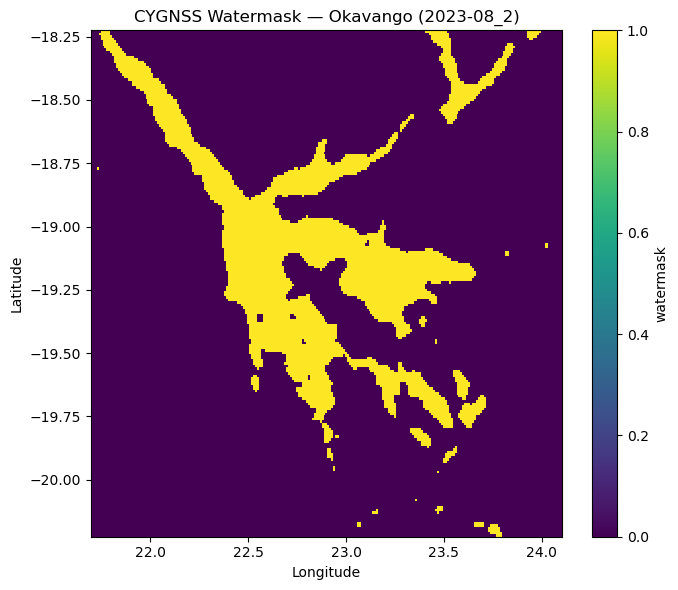

In [13]:
# --- One-month trial (e.g., Aug 2023) ---
TRIAL_RANGE = ("2023-08-01", "2023-09-01")  # end is exclusive

ea.login()
trial_results = ea.search_data(
    short_name=SHORT_NAME,
    version=VERSION,
    temporal=TRIAL_RANGE,
)
assert trial_results, "No granules found for the trial month."

trial_files = ea.open(trial_results)

# Pass BOTH the file-like object and its granule to keep YYYY-MM naming
trial_path = crop_and_save_nc(trial_files[0], trial_results[0], idx=0, bbox=OKAV_BBOX)
print("Trial file written:", trial_path)

# visualize
ds_trial = xr.open_dataset(trial_path, decode_times=False)
lat, lon = find_lat_lon_names(ds_trial)
varname  = pick_var_with_latlon(ds_trial, lat, lon)
da = ds_trial[varname]
tdim = next((d for d in da.dims if d.lower().startswith("time")), None)
if tdim is not None:
    da = da.isel({tdim: 0}).squeeze(drop=True)

plt.figure(figsize=(7,6))
plt.pcolormesh(ds_trial[lon], ds_trial[lat], da, shading="auto")
plt.colorbar(label=varname)
plt.title(f"CYGNSS Watermask — Okavango ({trial_path.stem.replace('okav_', '')})")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.tight_layout(); plt.show()
ds_trial.close()
